## Load libraries

In [1]:
import yt
import caesar
import numpy as np
import matplotlib.pyplot as plt
import unyt

import os
from glob import glob
from pathlib import Path

# For Swift Emulator training and validation
import swiftemulator as se
from swiftemulator.design import latin
from swiftemulator.io.swift import load_parameter_files
from swiftemulator.emulators import gaussian_process, gaussian_process_mcmc, gaussian_process_bins
from swiftemulator.mean_models.polynomial import PolynomialMeanModel
from swiftemulator.sensitivity import basic, cross_check, cross_check_bins
from swiftemulator.mocking import mock_sweep

# For reading in and checking observational data
import swiftpipeline as sp

from velociraptor.observations import load_observation, load_observations
from swiftemulator.comparison.penalty import L2PenaltyCalculator
from swiftemulator.comparison.visualisation import visualise_penalties_mean, visualise_penalties_generic_statistic


# For fitting model to data
from scipy.optimize import minimize

import emcee
import corner
from scipy.stats import norm

/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load simulated data (galaxy functions, scaling relations, ...)

In [2]:
num_calis = 16
cali_list = ["cali_%04d" % i for i in range(num_calis)]
print(cali_list)

['cali_0000', 'cali_0001', 'cali_0002', 'cali_0003', 'cali_0004', 'cali_0005', 'cali_0006', 'cali_0007', 'cali_0008', 'cali_0009', 'cali_0010', 'cali_0011', 'cali_0012', 'cali_0013', 'cali_0014', 'cali_0015']


In [3]:
snap_prefix = 'doug_s18n128'
snap_num = '0015'
snap_dir = '/scratch/b/babul/aspadawe/swift_tests/cali_simba'

In [4]:
gsmf_logM = []
gsmf_logPhi = []
gsmf_length = []

for cali in cali_list:
    gsmf_file = os.path.join(snap_dir, cali, snap_prefix+'_gsmf_'+snap_num+'.txt')
    print(gsmf_file)

    # Right now, saved log(M) and Phi, but emulator works better
    # on both axes logged, so need to log Phi as well (can change later)
    data = np.loadtxt(gsmf_file)
    logM = data[:,0]
    logPhi = np.log10(data[:,1])
    
    # Sanitize data of -inf, +inf, NaN values
    # Data for different simulations may have different array lengths
    isfinite = np.isfinite(logPhi)
    logM = logM[isfinite]
    logPhi = logPhi[isfinite]
    
    gsmf_logM.append(logM)
    gsmf_logPhi.append(logPhi)
    gsmf_length.append(len(logM))

/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0000/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0001/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0002/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0003/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0004/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0005/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0006/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0007/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0008/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0009/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0010/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_

/tmp/ipykernel_105061/1063982731.py:13: RuntimeWarning: divide by zero encountered in log10
  logPhi = np.log10(data[:,1])


[-1.31608205 -1.86892401]


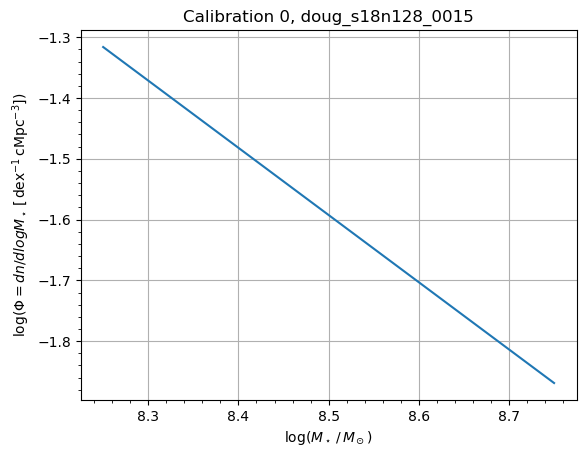

[-1.35545274 -1.7932033 ]


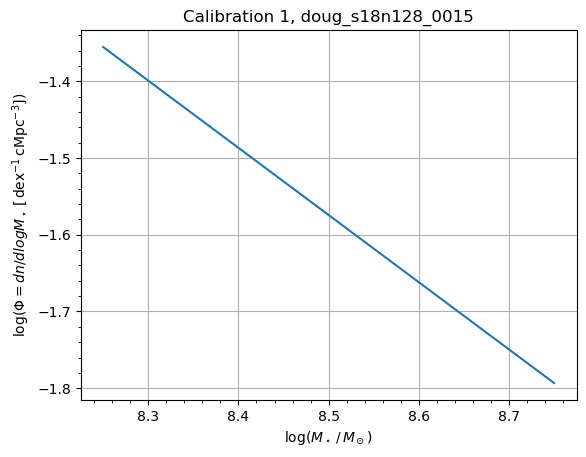

[-1.36832166 -1.80197722]


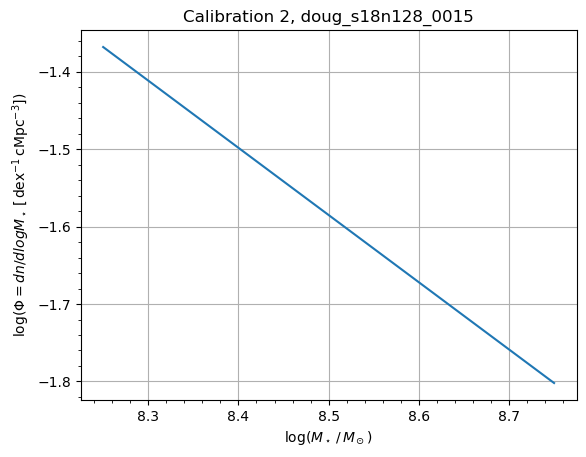

[-1.36183954 -1.75181062]


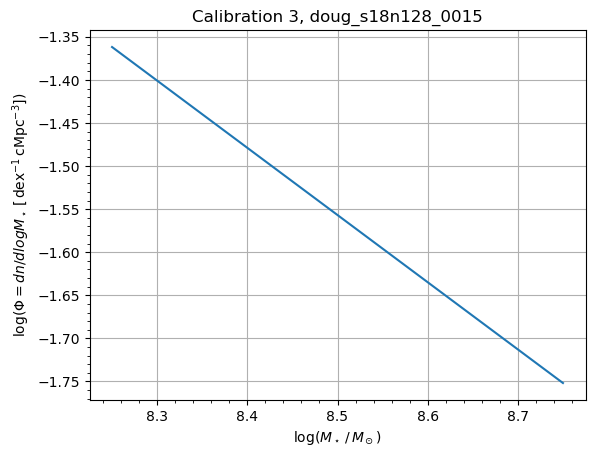

[-1.29627365 -1.91238971]


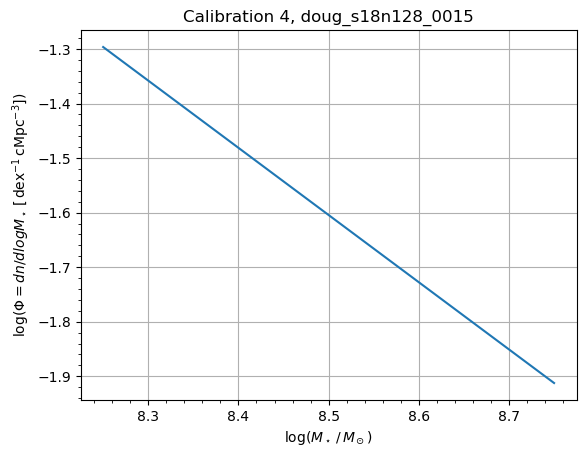

[-1.34295419 -1.7932033 ]


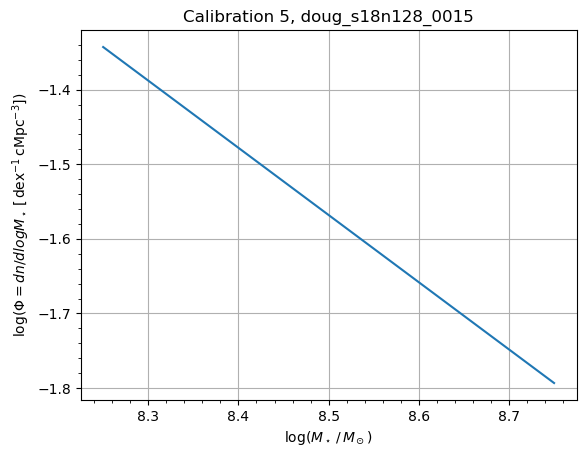

[-1.31608205 -1.63484081 -3.19114331]


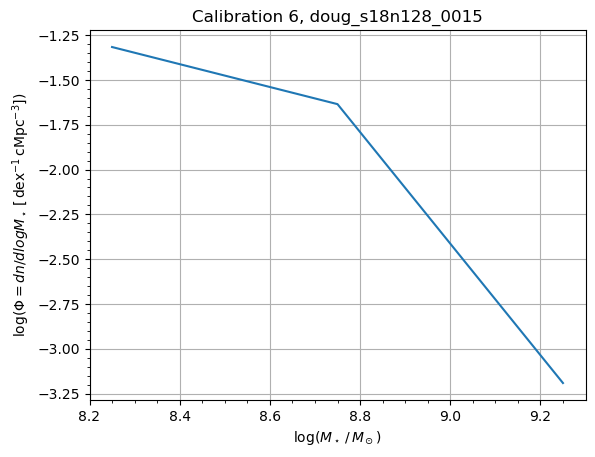

[-1.42771532 -1.83896079]


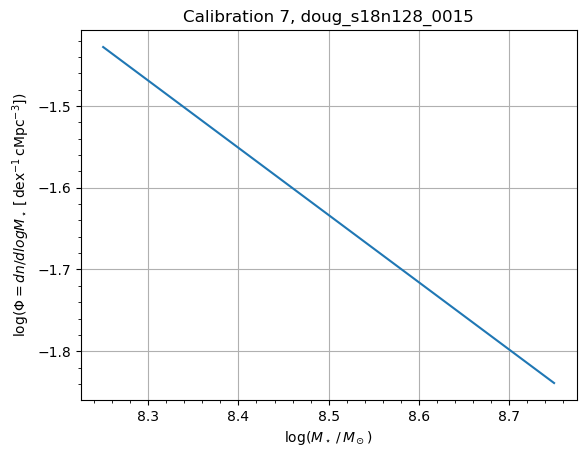

[-1.36832166 -1.78460313]


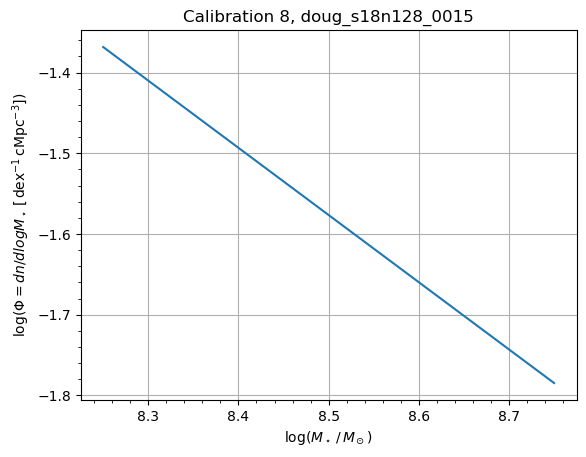

[-1.29904871 -1.72132129 -3.19114331 -3.4921733 ]


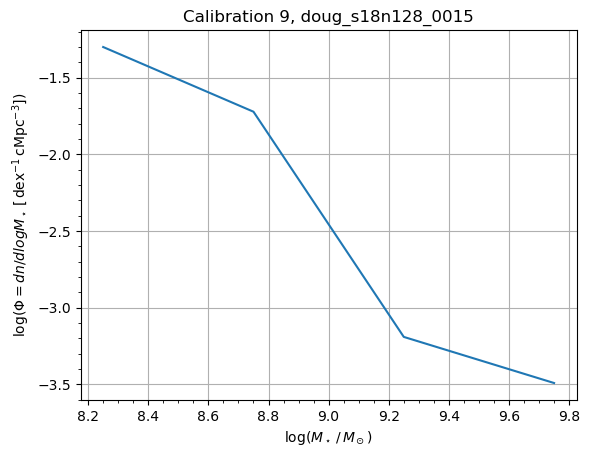

[-1.32485597 -1.76789744]


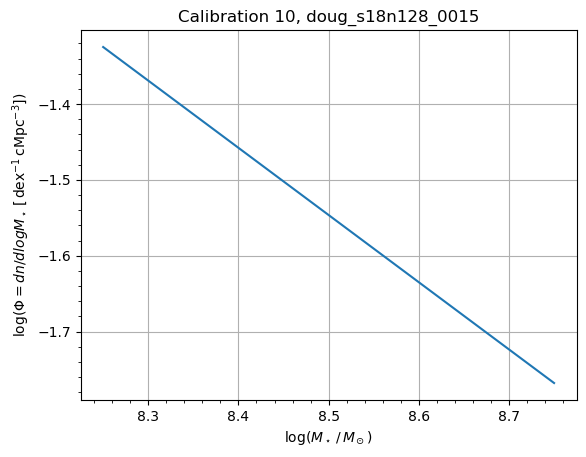

[-1.39875162 -1.84872063]


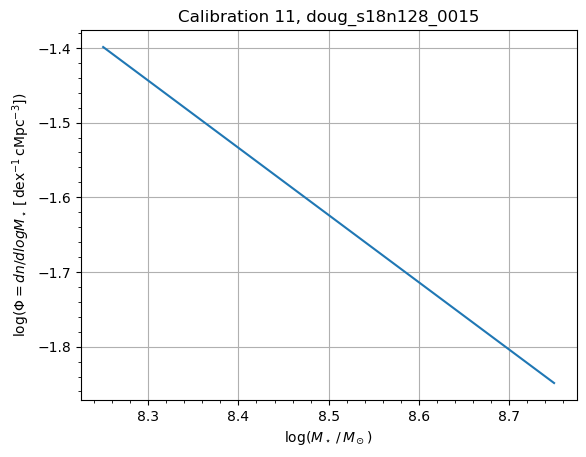

[-1.33381081 -1.81093207 -3.4921733 ]


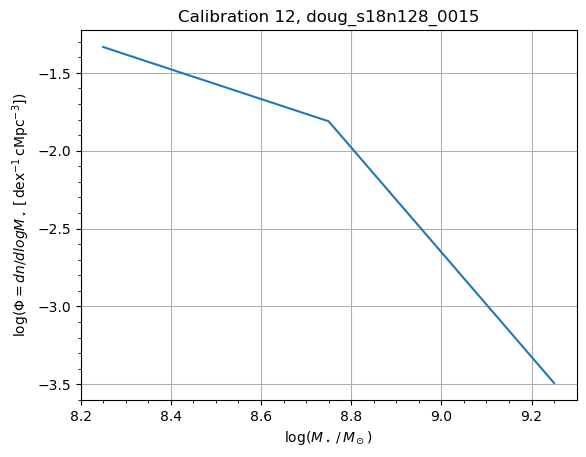

[-1.37490201 -1.75181062 -3.4921733 ]


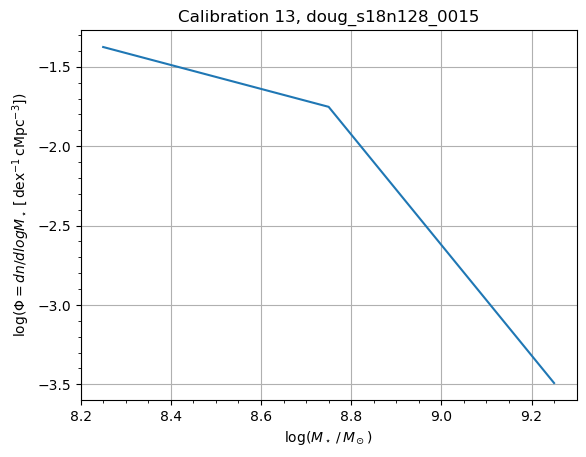

[-1.3308053  -1.76789744 -3.4921733 ]


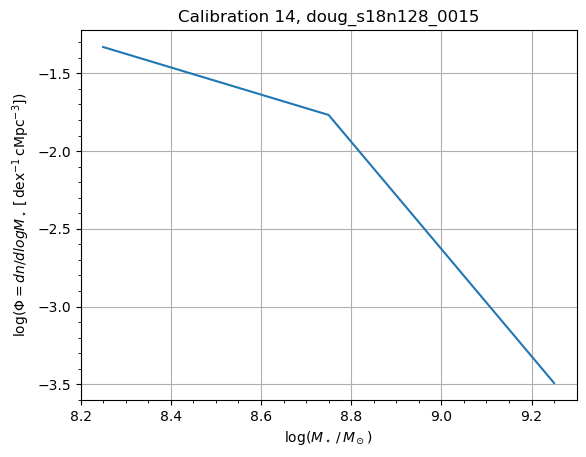

[-1.37822995 -1.74398528]


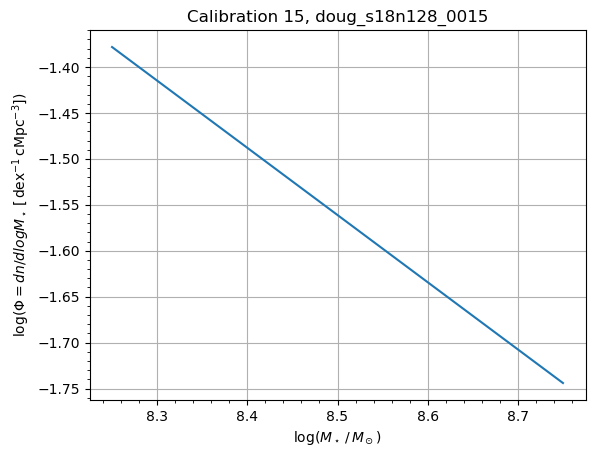

In [5]:
# Plot the GSMFs to check it worked

for check in range(num_calis):
    print(gsmf_logPhi[check])

    plt.clf()
    plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
    plt.ylabel(r'$\log(\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
    plt.title(r'Calibration %s, %s_%s' % (check, snap_prefix, snap_num))
    plt.grid()
    plt.minorticks_on()
    plt.plot(gsmf_logM[check],gsmf_logPhi[check],ls='-')
    plt.show()

## Specify the model parameters and values

In [6]:
parameter_files = [Path(x) for x in glob("/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/*.yml")]
parameter_filenames = {filename.stem: filename for filename in parameter_files}

In [7]:
model_specification, model_parameters = load_parameter_files(
    filenames=parameter_filenames,
    parameters=[
        "SIMBAAGN:xray_f_gas_limit",
        "SIMBAAGN:f_accretion",
        "SIMBAAGN:torque_accretion_norm",
        "SIMBAAGN:wind_momentum_flux"
    ],
    log_parameters=[
    ],
    parameter_printable_names=[
        "$f_{\\rm gas,xray}$",
        "$f_{\\rm acc}$",
        "$\epsilon_{\\rm torque}$",
        "Momentum flux"
    ],
)

In [8]:
modelvalues = {}
for unique_identifier in model_parameters.model_parameters:
    independent = gsmf_logM[int(unique_identifier)]
    dependent = gsmf_logPhi[int(unique_identifier)]
    dependent_error = 0.0 * dependent
    modelvalues[unique_identifier] = {"independent": independent,
                                    "dependent": dependent,
                                    "dependent_error": dependent_error}

model_values = se.ModelValues(model_values=modelvalues)

## Train emulator

In [9]:
gsmf_emulator = gaussian_process.GaussianProcessEmulator()  # Default
#gsmf_emulator = gaussian_process_bins.GaussianProcessEmulatorBins()  # Binned
#polynomial_model = PolynomialMeanModel(degree=2)  # Polynomial mean model
#gsmf_emulator = gaussian_process.GaussianProcessEmulator(mean_model=polynomial_model)  # Mean model

gsmf_emulator.fit_model(model_specification=model_specification,
                            model_parameters=model_parameters,
                            model_values=model_values)

## Make predictions and compare

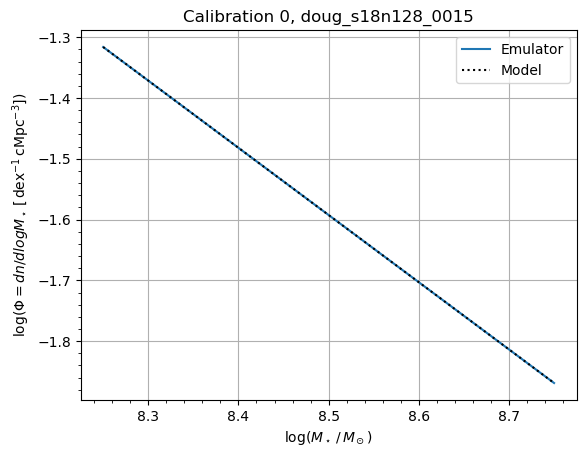

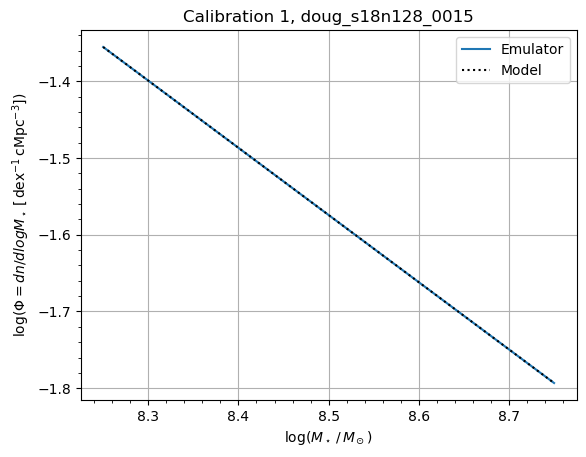

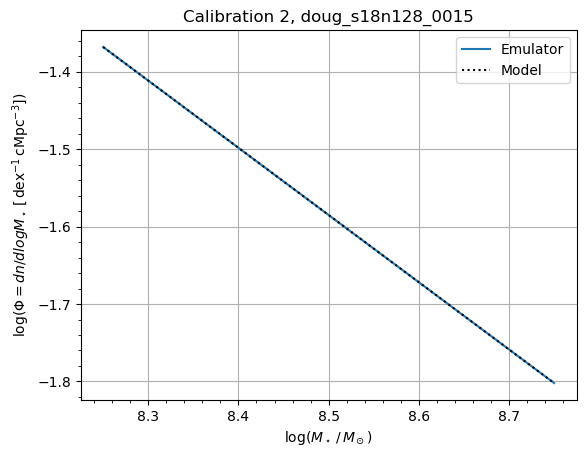

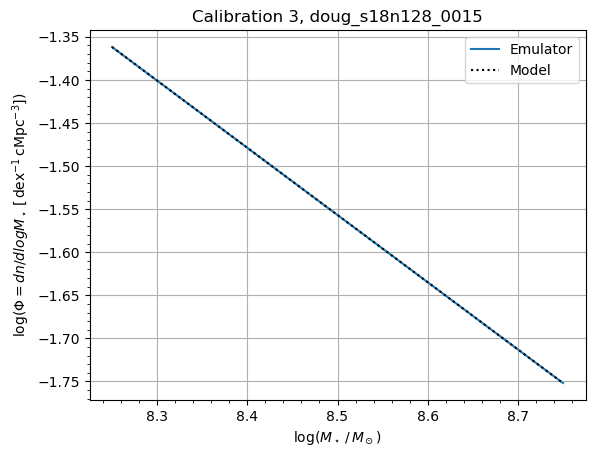

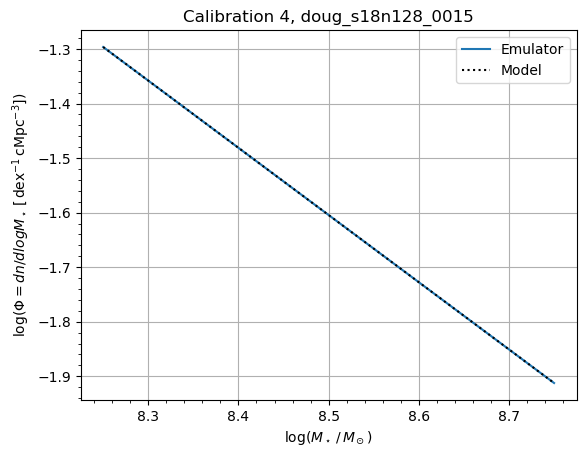

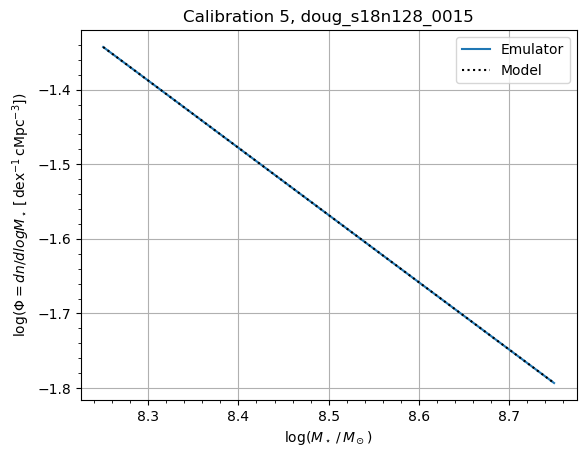

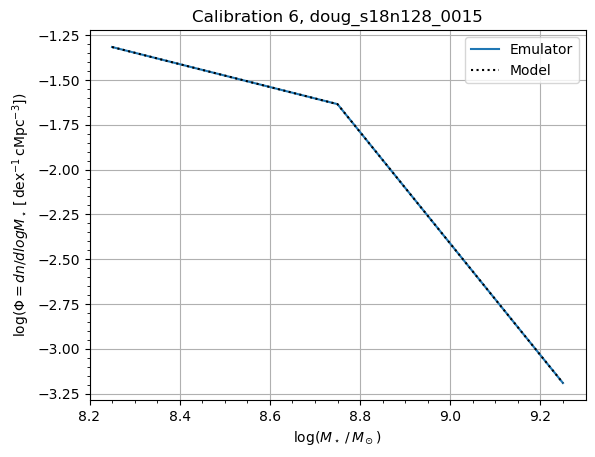

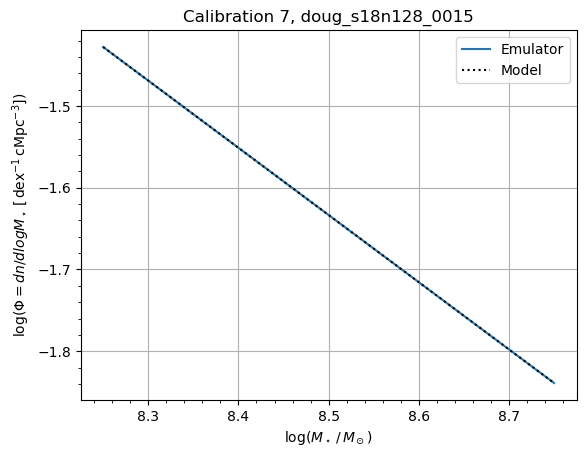

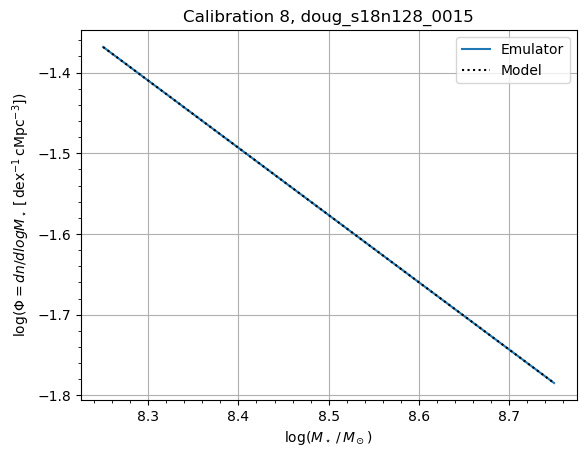

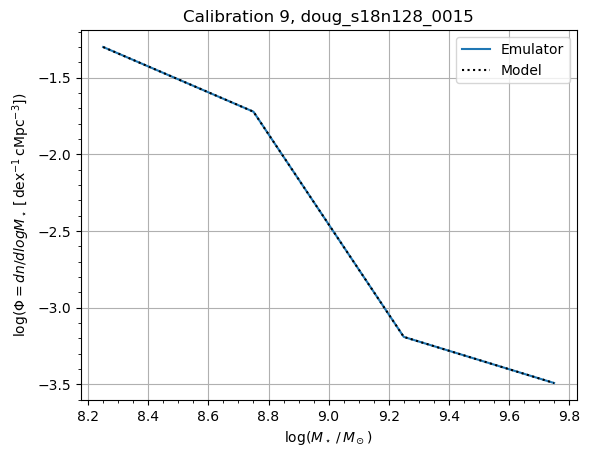

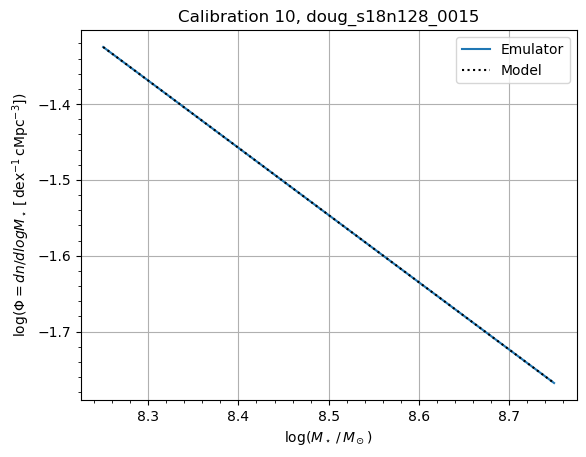

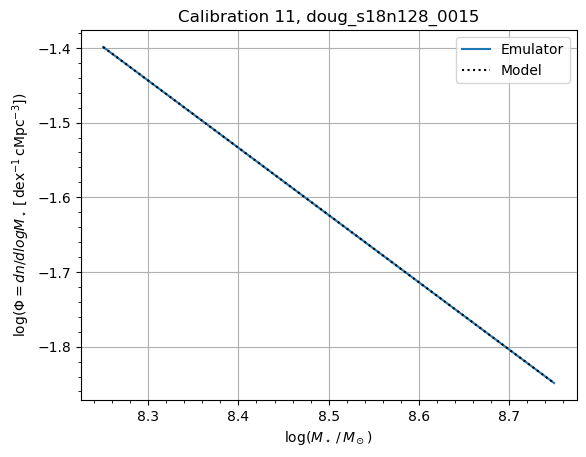

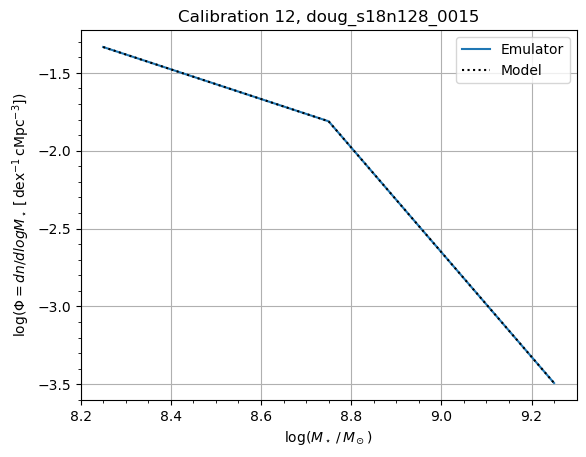

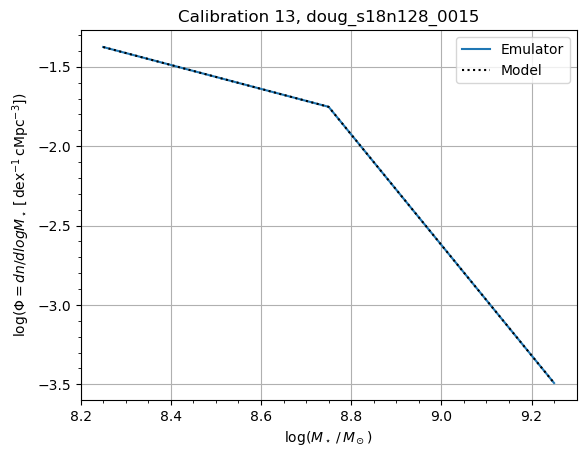

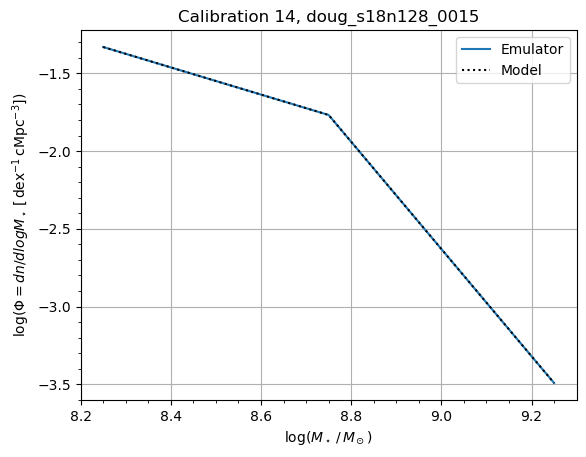

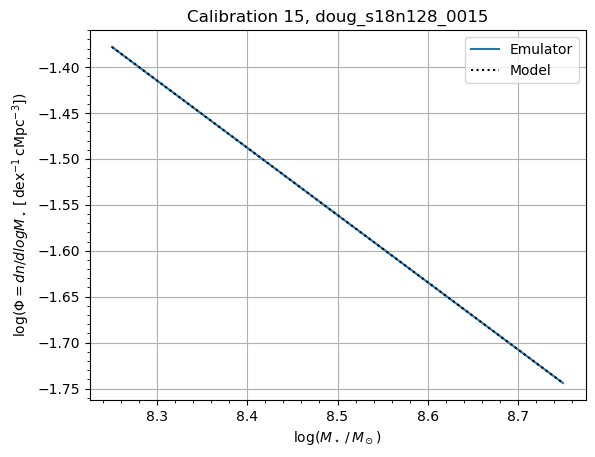

In [10]:
# Make predictions with trained emulator to compare to input

for ii in range(num_calis):
    num = str(ii)
    pred_params = model_parameters[num]
    pred_x = gsmf_emulator.model_values[num]['independent']
    sim_y = gsmf_emulator.model_values[num]['dependent']

    pred_y, pred_var = gsmf_emulator.predict_values(pred_x, pred_params)

    plt.clf()
    plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
    plt.ylabel(r'$\log (\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
    plt.title(r'Calibration %s, %s_%s' % (ii, snap_prefix, snap_num))
    plt.grid()
    plt.minorticks_on()
    plt.plot(pred_x, pred_y,ls='-', label='Emulator')
    plt.plot(pred_x, sim_y, color="black", ls=":", label="Model")
    plt.legend()
    plt.show()

## Perform cross check (validation)

In [11]:
gsmf_ccheck = cross_check.CrossCheck()
gsmf_ccheck.build_emulators(model_specification=model_specification,
                        model_parameters=model_parameters,
                        model_values=model_values)

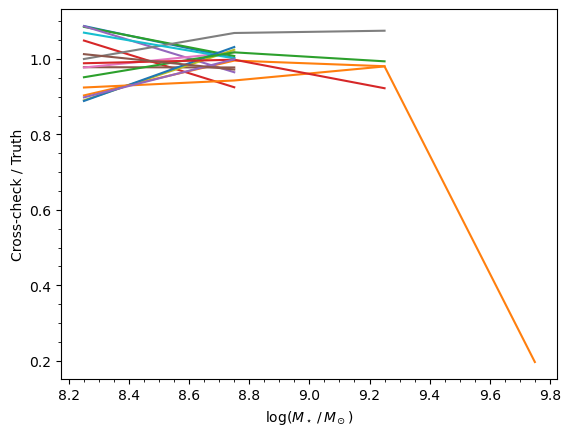

In [12]:
data_by_cc = gsmf_ccheck.build_mocked_model_values_original_independent()

for unique_identifier in model_values.model_values:
    cc_over_og = data_by_cc[unique_identifier]["dependent"] / \
                model_values[unique_identifier]["dependent"]
#    cc_minus_og_over_og = (data_by_cc[unique_identifier]["dependent"] / \
#                           model_values[unique_identifier]["dependent"])/ model_values[unique_identifier]["dependent"]
    plt.plot(data_by_cc[unique_identifier]["independent"],cc_over_og)
    plt.grid()
    plt.minorticks_on()
    plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
    plt.ylabel("Cross-check / Truth")

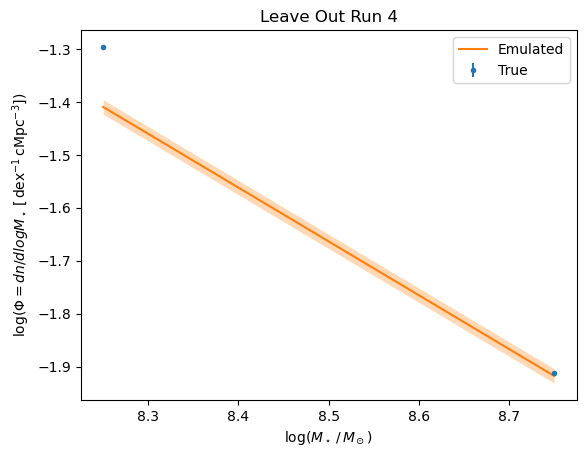

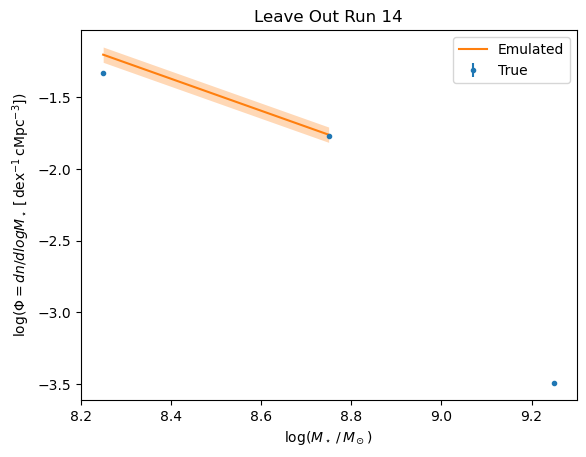

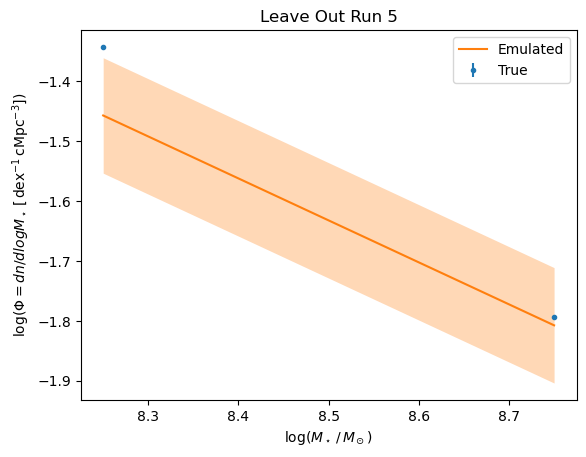

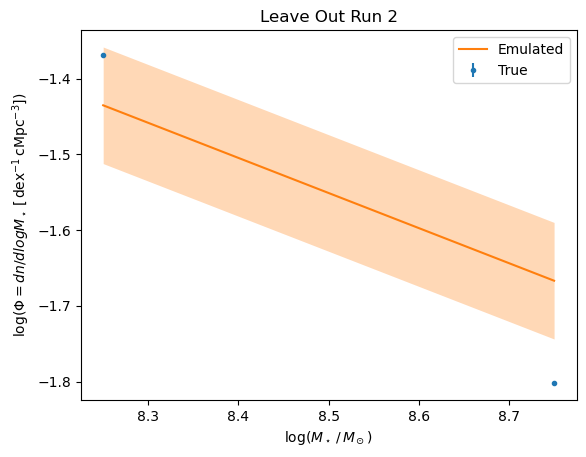

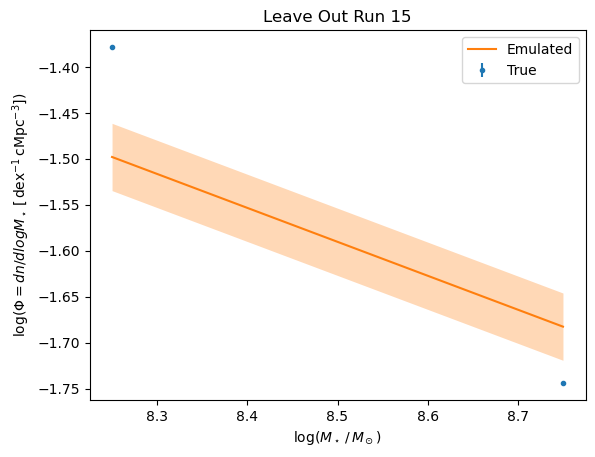

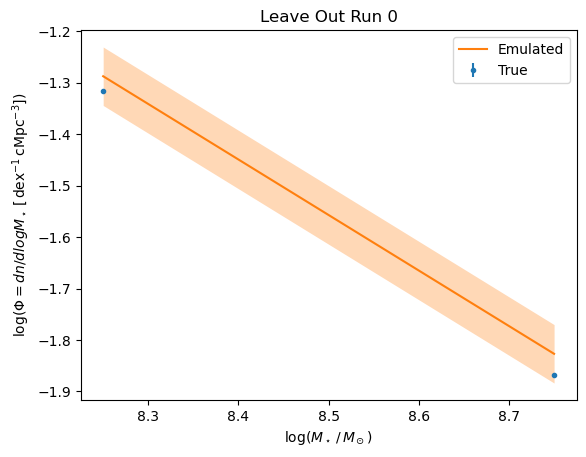

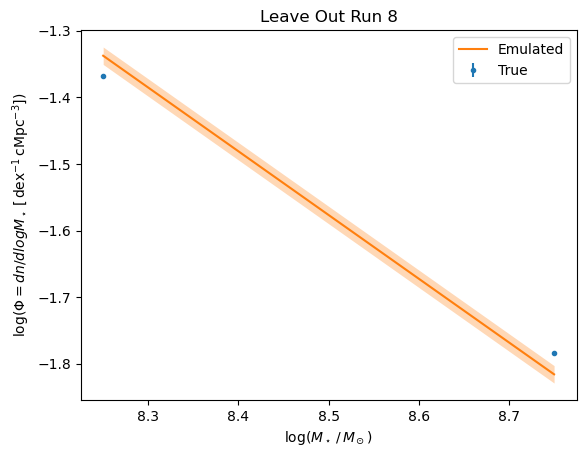

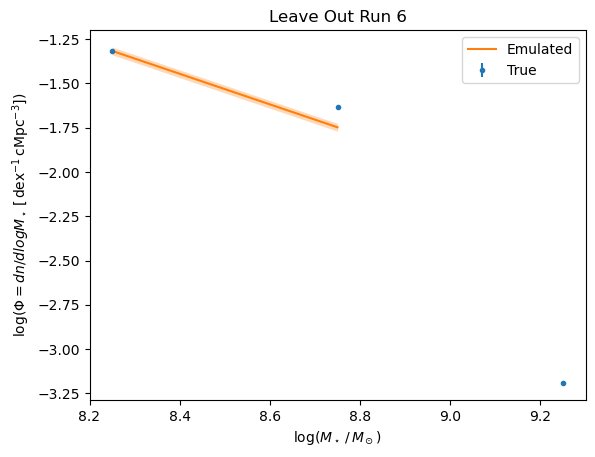

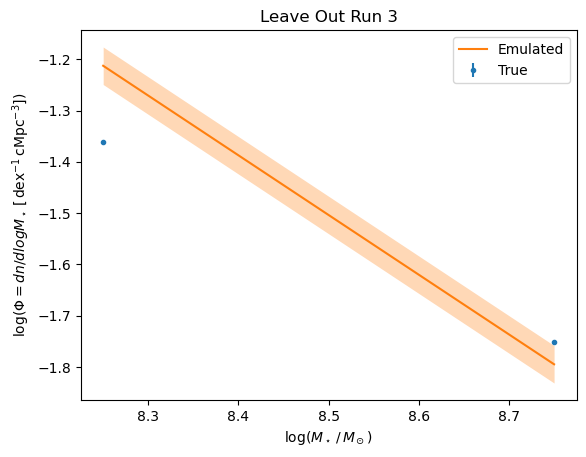

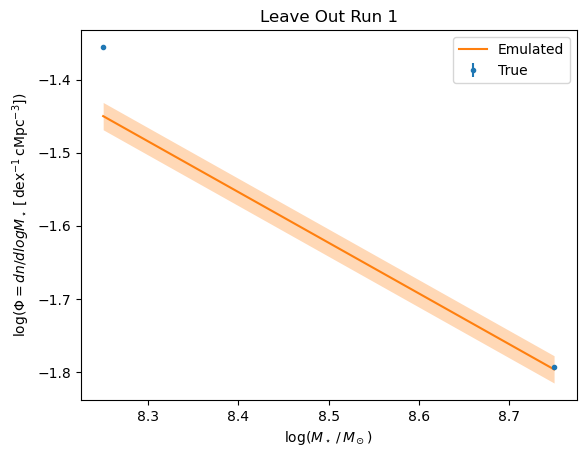

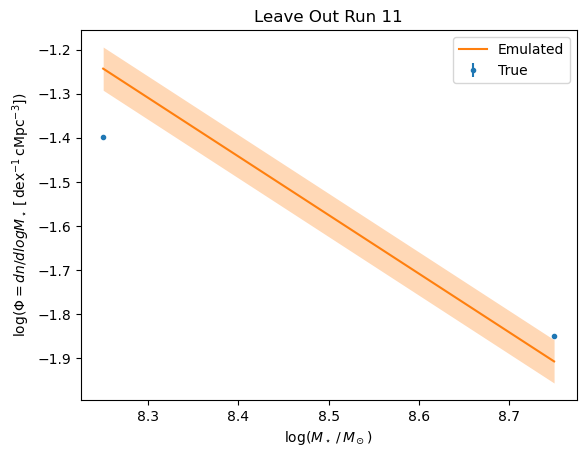

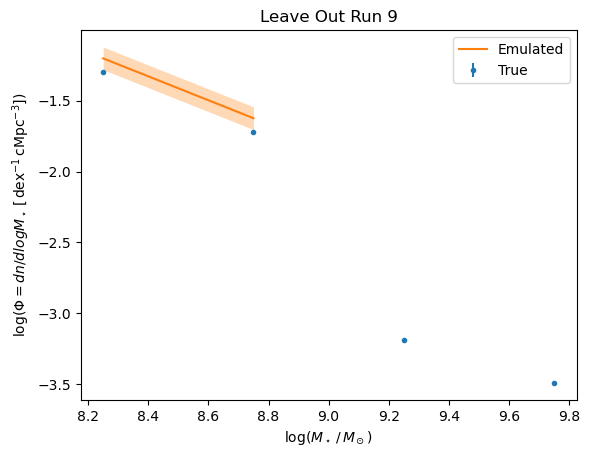

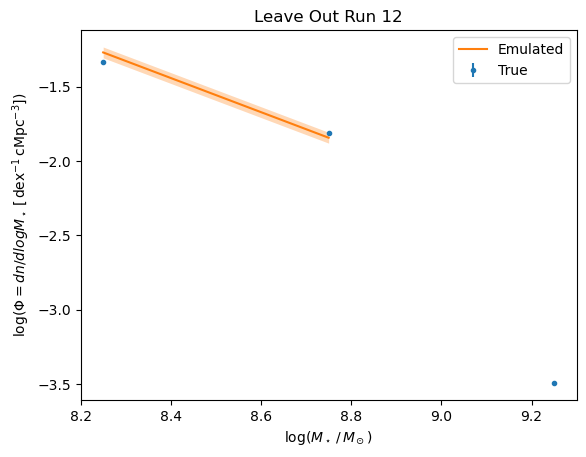

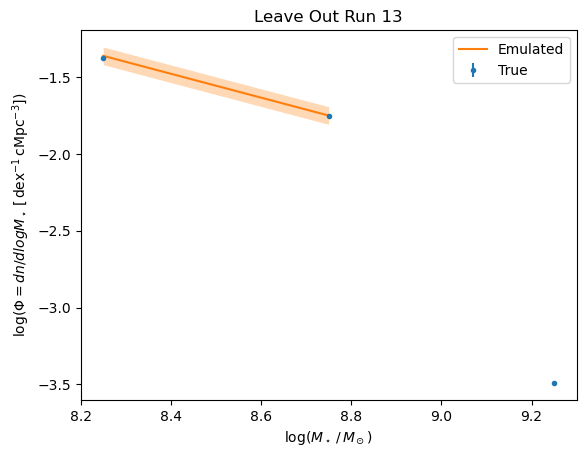

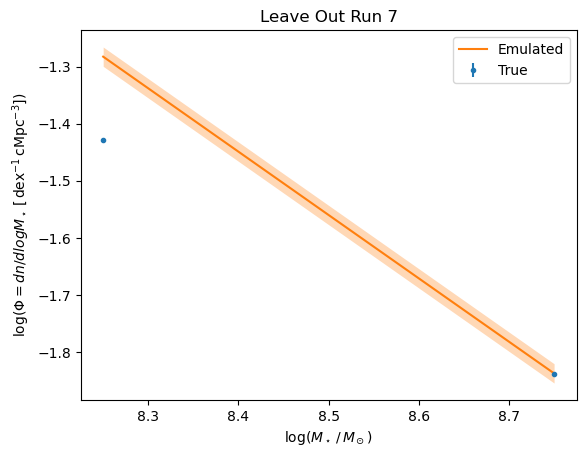

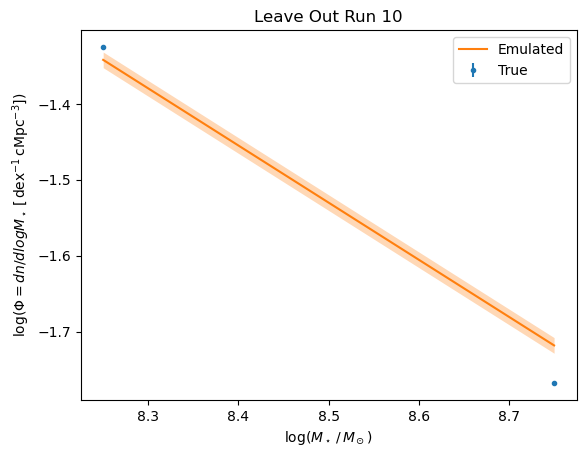

In [13]:
gsmf_ccheck.plot_results(emulate_at=data_by_cc[unique_identifier]["independent"],
                        xlabel=r'$\log(M_\star\,/\,M_\odot)$',
                        ylabel=r'$\log (\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')

In [14]:
total_mean_squared = gsmf_ccheck.get_mean_squared()[0]
print("Total mean squared of entire set of left-out simulations: %s" % total_mean_squared)

Total mean squared of entire set of left-out simulations: 0.21630998746094904


## Model Parameter Features

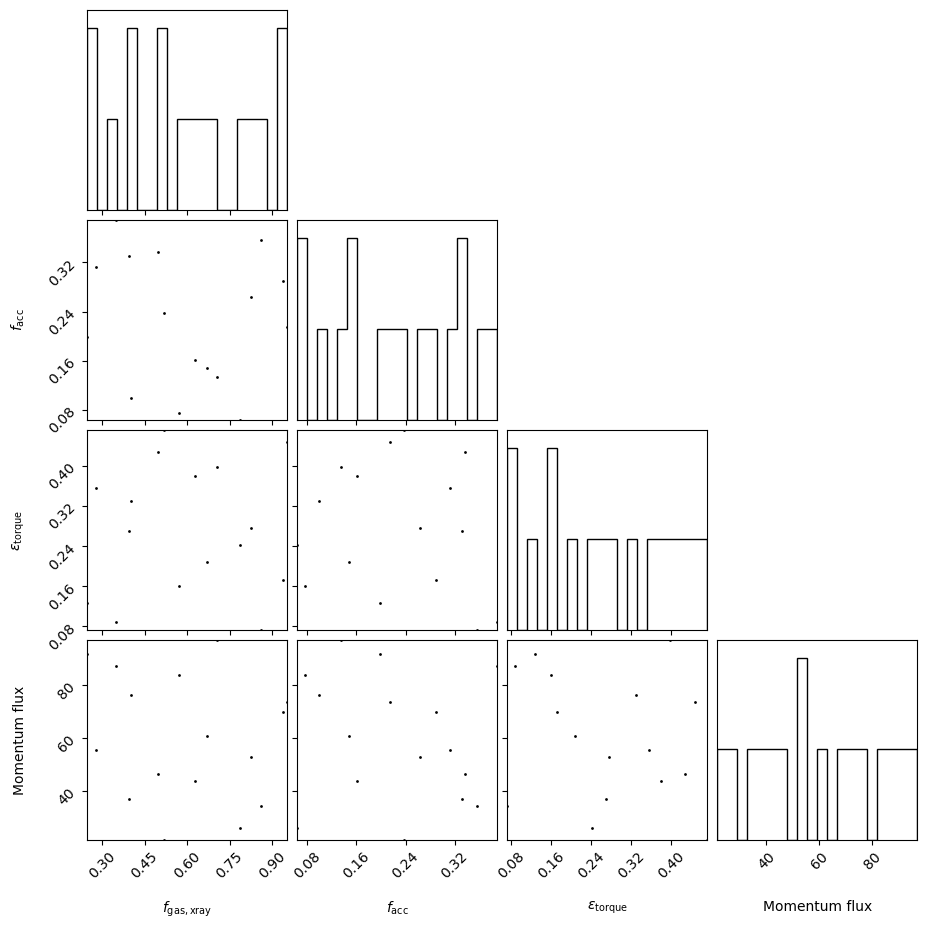

In [15]:
model_parameters.plot_model(model_specification)

In [16]:
# Models closest to specific model

specific_model = gsmf_emulator.model_parameters['0']
model_parameters.find_closest_model(specific_model, number_of_close_models=5)

(['0', '12', '3', '6', '10'],
 [{'SIMBAAGN:xray_f_gas_limit': 0.9535354367676403,
   'SIMBAAGN:f_accretion': 0.21475691826279325,
   'SIMBAAGN:torque_accretion_norm': 0.4475036358483602,
   'SIMBAAGN:wind_momentum_flux': 73.62769640233914},
  {'SIMBAAGN:xray_f_gas_limit': 0.40187076318649934,
   'SIMBAAGN:f_accretion': 0.09897074647673551,
   'SIMBAAGN:torque_accretion_norm': 0.32992087498483613,
   'SIMBAAGN:wind_momentum_flux': 75.96049144263723},
  {'SIMBAAGN:xray_f_gas_limit': 0.9396273438695912,
   'SIMBAAGN:f_accretion': 0.28909115515459843,
   'SIMBAAGN:torque_accretion_norm': 0.1719681283477677,
   'SIMBAAGN:wind_momentum_flux': 69.56978679165695},
  {'SIMBAAGN:xray_f_gas_limit': 0.5701273027190352,
   'SIMBAAGN:f_accretion': 0.07541927270328372,
   'SIMBAAGN:torque_accretion_norm': 0.15996305465419988,
   'SIMBAAGN:wind_momentum_flux': 83.82898331458352},
  {'SIMBAAGN:xray_f_gas_limit': 0.6706117490018764,
   'SIMBAAGN:f_accretion': 0.14724561528138613,
   'SIMBAAGN:torque_acc

## Sweeps of parameter space

{'SIMBAAGN:xray_f_gas_limit': 0.9535354367676403, 'SIMBAAGN:f_accretion': 0.21475691826279325, 'SIMBAAGN:torque_accretion_norm': 0.4475036358483602, 'SIMBAAGN:wind_momentum_flux': 73.62769640233914}


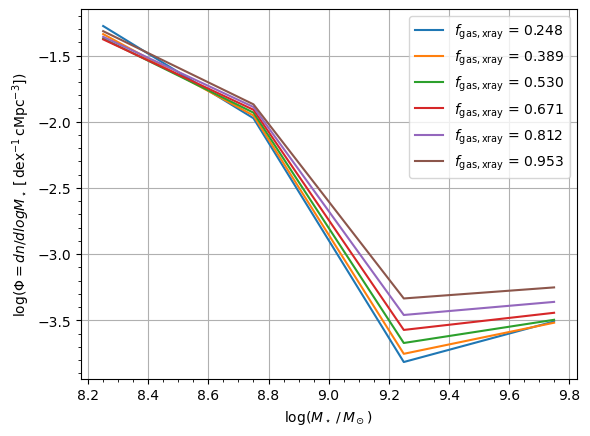

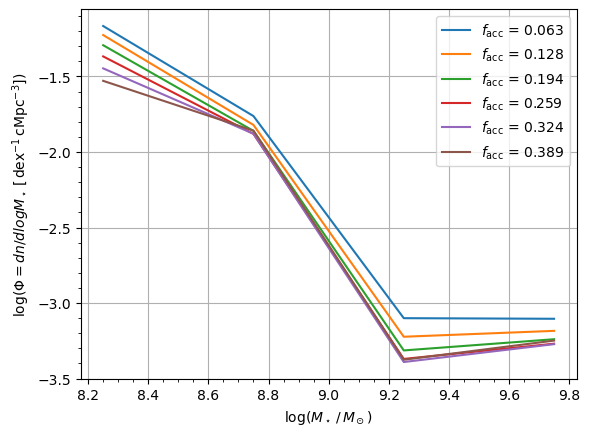

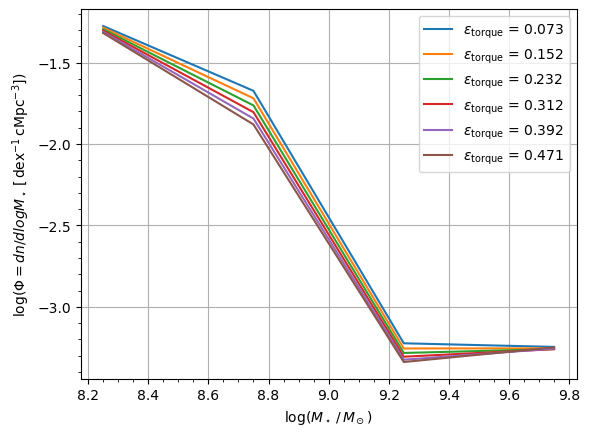

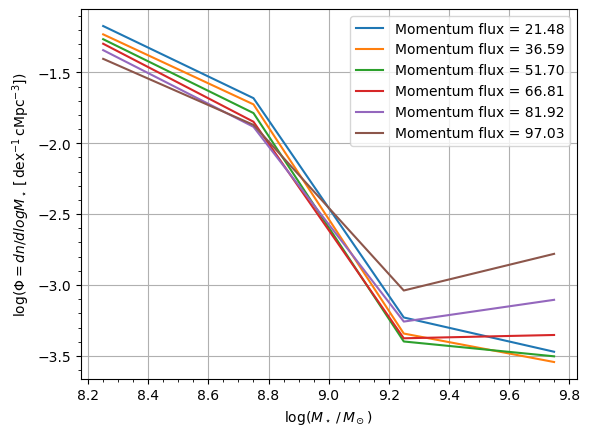

In [17]:
# Arbitrarily choose initial parameters to sweep from
# Doesn't matter too much though, because it ends up covering
# roughly the entire range of parameters used
# Although it seems the emulator results are somewhat sensitive to the exact parameters used

center = gsmf_emulator.model_parameters['0']
print(center)

param_printable_names = []
for ii in range(len(gsmf_emulator.parameter_order)):
    param_name = gsmf_emulator.parameter_order[ii]
    param_printable_name = gsmf_emulator.model_specification.parameter_printable_names[ii]
    param_printable_names.append(param_printable_name)
    
    Mock_values, Mock_parameters = mock_sweep(gsmf_emulator
                                      ,model_specification
                                      ,6,param_name,center)
    plt.clf()   
    for mock_name in Mock_values.keys():
        plt.plot(Mock_values[mock_name]["independent"],
                Mock_values[mock_name]["dependent"],
                label = "%s = " % param_printable_name +str(Mock_parameters[mock_name][param_name])[:5])
    
    plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
    plt.ylabel(r'$\log (\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()

# Compare with observational data

## Load observational data

In [18]:
observation = load_observations(
    "/home/b/babul/aspadawe/data/gsmf/Baldry12_gsmf_schechter.hdf5"
)[0]
print(observation.cosmology)

FlatLambdaCDM(name="Flat $\Lambda$CDM", H0=70.0 km / (Mpc s), Om0=0.3, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.0)


## Penalty function

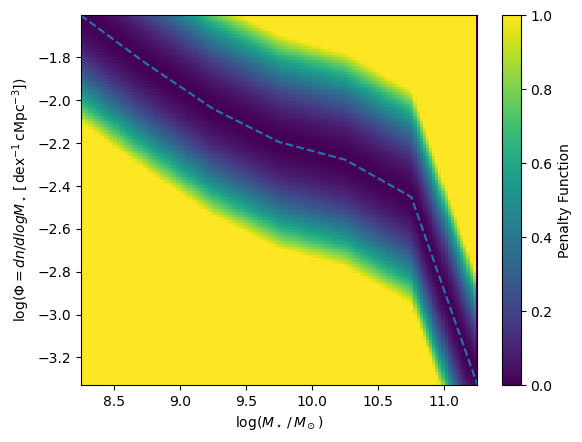

In [19]:
L2_penalty = L2PenaltyCalculator(offset = 0.5, lower=min(np.log10(observation.x)),upper=max(np.log10(observation.x)))
L2_penalty.register_observation(observation,
                                log_independent=True,
                                log_dependent=True,
                                independent_units=unyt.Msun,
                                dependent_units=unyt.Mpc**-3)

L2_penalty.plot_penalty(min(np.log10(observation.x)),max(np.log10(observation.x)),
                        min(np.log10(observation.y)),max(np.log10(observation.y)),
                        "penalty_example",
                        x_label=r'$\log(M_\star\,/\,M_\odot)$',
                        y_label=r'$\log (\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$',
                       resolution=128)

In [20]:
# Check which input simulation best fits the observational data

all_penalties = L2_penalty.penalties(gsmf_emulator.model_values, np.mean)

all_penalties_array = []
node_number = []
for key in all_penalties.keys():
    all_penalties_array.append(all_penalties[key])
    node_number.append(int(key))

best_node = node_number[np.argmin(all_penalties_array)]

print("Best fit node = ", best_node)

pred_params_best_node = gsmf_emulator.model_parameters[str(best_node)].copy()
print(pred_params_best_node)

Best fit node =  7
{'SIMBAAGN:xray_f_gas_limit': 0.49710081592469346, 'SIMBAAGN:f_accretion': 0.3372717158177846, 'SIMBAAGN:torque_accretion_norm': 0.4277111868636051, 'SIMBAAGN:wind_momentum_flux': 46.38910175409183}


In [21]:
# Check penalty of best fit node

pred_params_best_node = gsmf_emulator.model_parameters[str(best_node)].copy()
x_to_predict = np.log10(L2_penalty.observation.x.value)  # x values of observational data (will likely give higher penalty)
#x_to_predict = gsmf_emulator.model_values[str(best_node)]['independent']  # only x values in the best-fit node (will likely give lower penalty)
pred_y, pred_var = gsmf_emulator.predict_values(x_to_predict, pred_params_best_node)

print("Mean Penalty of node %s = %s" % (best_node, np.mean(L2_penalty.penalty(x_to_predict, pred_y))))

#Let's change one of the parameters and see if it improves the fit
pred_params_change = pred_params_best_node.copy()
pred_params_change["SIMBAAGN:xray_f_gas_limit"] += 0.1
pred_y, pred_var = gsmf_emulator.predict_values(x_to_predict, pred_params_change)

print("Mean after change = %s" % np.mean(L2_penalty.penalty(x_to_predict, pred_y)))

Mean Penalty of node 7 = 0.6876063838995119
Mean after change = 0.6833324792953376


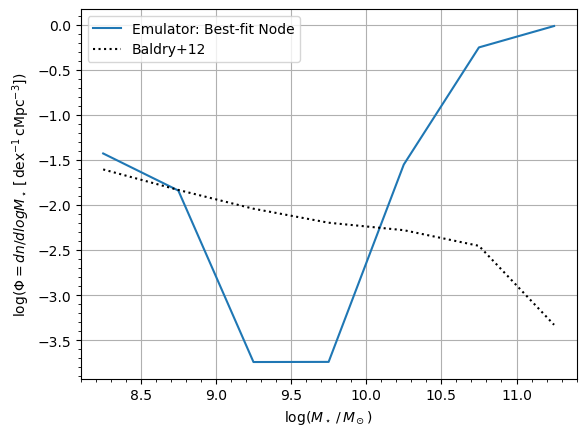

In [22]:
# Plot best fit node and data

pred_x = np.log10(L2_penalty.observation.x.value)
pred_y, pred_var = gsmf_emulator.predict_values(pred_x, pred_params_best_node)

plt.clf()
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\log(\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
plt.grid()
plt.minorticks_on()
plt.plot(pred_x, pred_y, ls='-', label='Emulator: Best-fit Node')
plt.plot(np.log10(observation.x), np.log10(observation.y), color="black", ls=":", label="Baldry+12")
plt.legend()
plt.show()

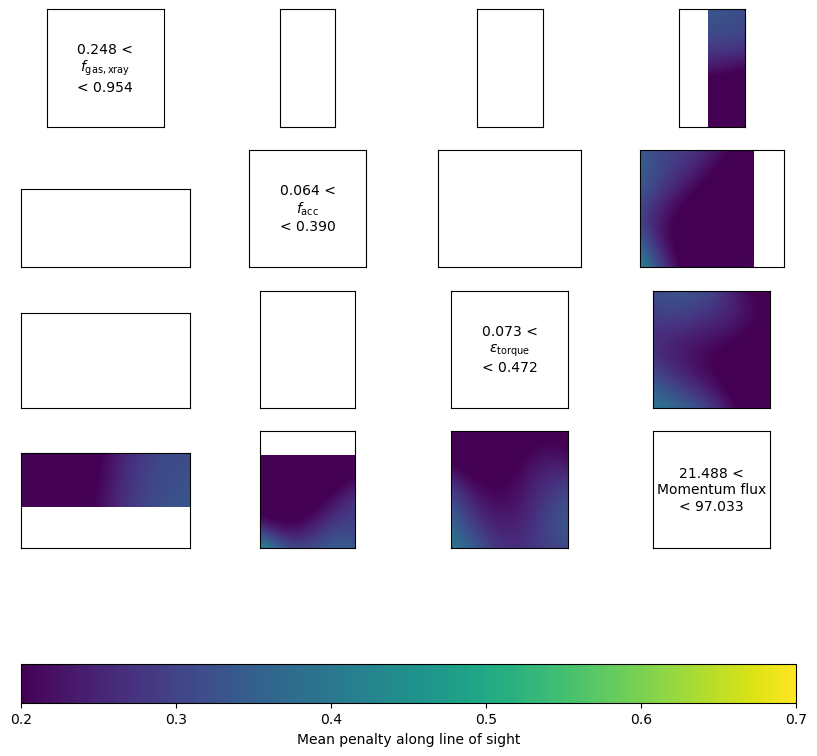

In [23]:
fig, ax = visualise_penalties_mean(gsmf_emulator.model_specification, gsmf_emulator.model_parameters, all_penalties,
                                   remove_ticks=True,
                                   figsize=(10,10),
#                                   use_parameters=["SIMBAAGN:xray_f_gas_limit"],
                                   use_colorbar=True)

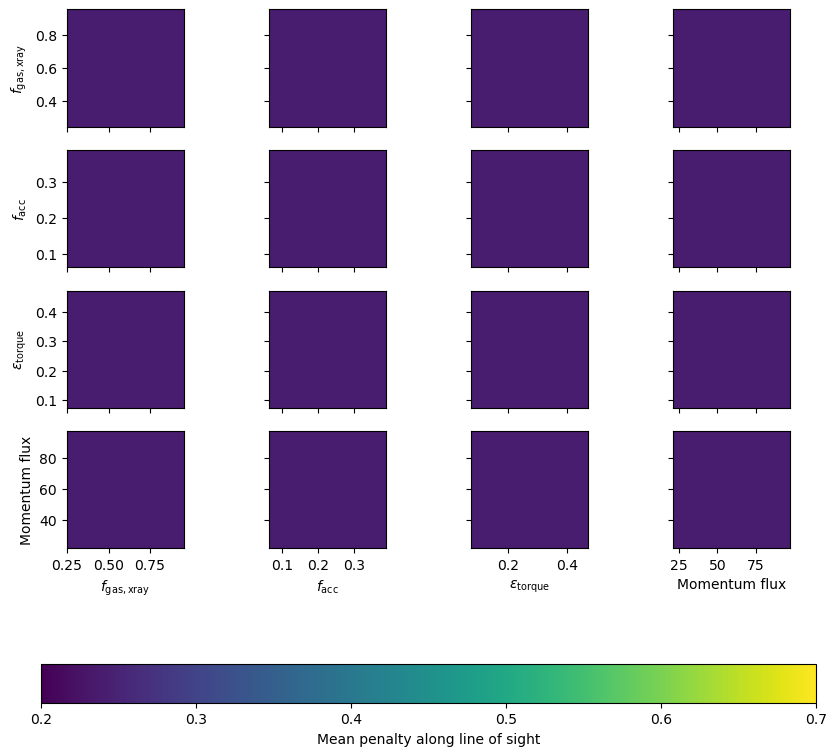

In [24]:
# Statistic options are: mean, std, median, count, sum, min, max, OR user defined function
fig, ax = visualise_penalties_generic_statistic(gsmf_emulator.model_specification, gsmf_emulator.model_parameters, all_penalties,
                                                statistic='mean',
                                               remove_ticks=False,
                                               figsize=(10,10),
#                                              use_parameters=["SIMBAAGN:xray_f_gas_limit"],
                                               use_colorbar=True)

## Fit emulator model to observational data

In [25]:
# Get min and max values of each parameter that go into original simulations
# They will be the MCMC limits

param_values_arr = np.zeros((len(gsmf_emulator.parameter_order), len(gsmf_emulator.model_parameters)), float)
param_mins_arr = np.zeros(len(gsmf_emulator.parameter_order), float)
param_maxs_arr = np.zeros(len(gsmf_emulator.parameter_order), float)

param_values = {}
param_mins = {}
param_maxs = {}

for param in gsmf_emulator.parameter_order:
    idx = gsmf_emulator.parameter_order.index(param)
    param_values[param] = list([])

    for mod, vals in gsmf_emulator.model_parameters.items():
        param_values[param].append(vals[param])
    
    param_mins[param] = min(param_values[param])
    param_maxs[param] = max(param_values[param])
    
    param_mins_arr[idx] = min(param_values[param])
    param_maxs_arr[idx] = max(param_values[param])

In [64]:
def model(theta, x=np.log10(L2_penalty.observation.x.value)):
    params = gsmf_emulator.model_parameters[str(best_node)].copy()
    for ii in range(len(theta)):
        key = list(params.keys())[ii]
        params[key] = theta[ii]

    val, var = gsmf_emulator.predict_values(x, params)
    return val


def lnlike(theta, x, y, yerr):
    m = model(theta, x)
    
#    LnLike = sum(norm.logpdf(y, loc=m, scale=yerr))  # One way to get LnLike with scipy.stats
#    LnLike = -0.5 * sum(np.power((y - m)/yerr, 2))  # Get likelihood (assuming indepenent Gaussian error bars?)
    
#    sigma2 = yerr**2 + m**2
#    LnLike = -0.5 * np.sum((y - m) ** 2 / sigma2 + np.log(sigma2))  # Likelihood (no assumptions?)

#    LnLike = -0.5 * sum(np.power((y - m), 2))  # If no error bars on data
    LnLike = np.mean(L2_penalty.penalty(x, m))  # if want to use L2 penalty (should be using mean?)
    
    return LnLike


def within_limits(theta):
    result = True
    for ii in range(len(theta)):
        result = result and (param_mins_arr[ii] <= theta[ii] <= param_maxs_arr[ii])
    return result

def lnprior(theta):
    if within_limits(theta):
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr) #recall if lp not -inf, its 0, so this just returns likelihood

In [40]:
# Separate out data into x, y, yerr
x = np.log10(L2_penalty.observation.x.value)#.value
y = np.log10(L2_penalty.observation.y.value)#.value
yerr = y/y  # no errors right now on schechter fit
data = (x, y, yerr)

In [41]:
# Get initial estimate of parameters from scipy optimizer
np.random.seed(42)
nll = lambda *args: -lnlike(*args)
initial_opt = list(pred_params_best_node.values())
soln = minimize(nll, initial_opt, args=data)
print(soln)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.6876063838995119
        x: [ 4.971e-01  3.373e-01  4.277e-01  4.639e+01]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 hess_inv: [[1 0 0 0]
            [0 1 0 0]
            [0 0 1 0]
            [0 0 0 1]]
     nfev: 5
     njev: 1


In [42]:
# Parameters for MCMC run
initial_mcmc = soln.x
ndim = len(initial_mcmc)
nburn = 100
niter = 10000
nwalkers = 32
p0 = [np.array(initial_mcmc) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [43]:
# Function for running burn-in and production iterations of MCMC
def main(p0, nwalkers, nburn, niter, ndim, lnprob, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

#    print("Running burn-in...")
#    p0, _, _ = sampler.run_mcmc(p0, nburn, progress=True)
#    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)
    
    print("Done")

    return sampler, pos, prob, state

In [50]:
# Execute MCMC
sampler, pos, prob, state = main(p0, nwalkers, nburn, niter, ndim, lnprob, data)

Running production...


100%|██████████| 10000/10000 [00:51<00:00, 193.47it/s]

Done


Text(0.5, 0, 'step number')

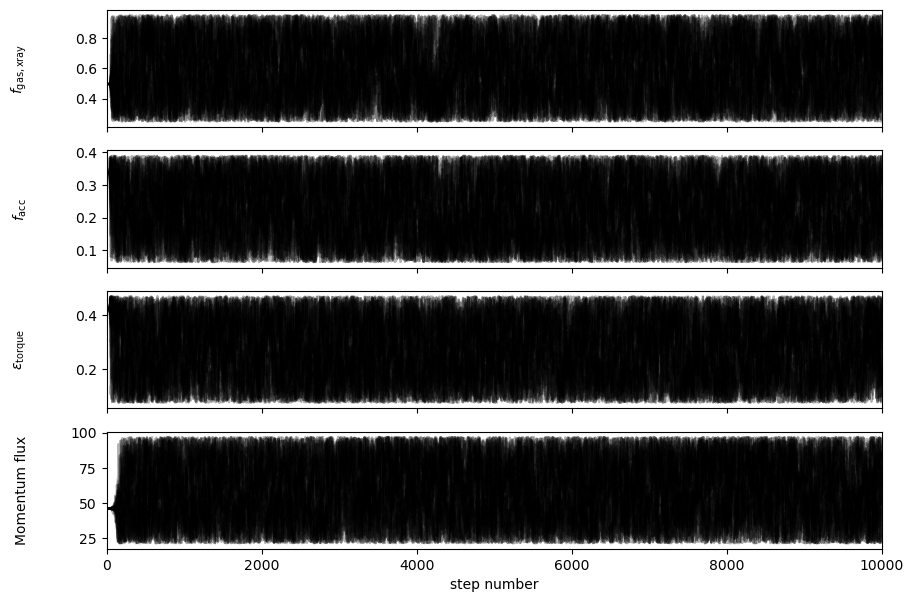

In [56]:
# Plot MCMC chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = param_printable_names
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [57]:
# Get autocorrelation time to determine burn-in required
tau = sampler.get_autocorr_time()
print(tau)

[108.63298322 105.31685565 116.39751396 122.68710268]


In [58]:
# Remove burn-in
nburn = int(np.mean(tau))
flat_samples = sampler.get_chain(discard=nburn, thin=int(nburn/2), flat=True)
#flat_samples = sampler.flatchain

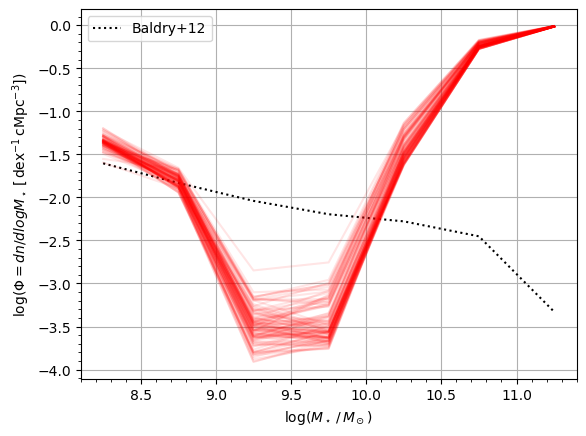

In [65]:
# Extract random sampling of posteriors and plot over data

plt.clf()
plt.plot(data[0], data[1], color="black", ls=":", label="Baldry+12")
for theta in flat_samples[np.random.randint(len(flat_samples), size=100)]:
    pred_mcmc = model(theta, x=data[0])
    plt.plot(data[0], pred_mcmc, color="r", alpha=0.1)
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\log(\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
plt.grid()
plt.minorticks_on()
plt.legend()
plt.show()

Theta max:  [9.06604280e-01 6.51367103e-02 1.05507781e-01 7.74218701e+01]


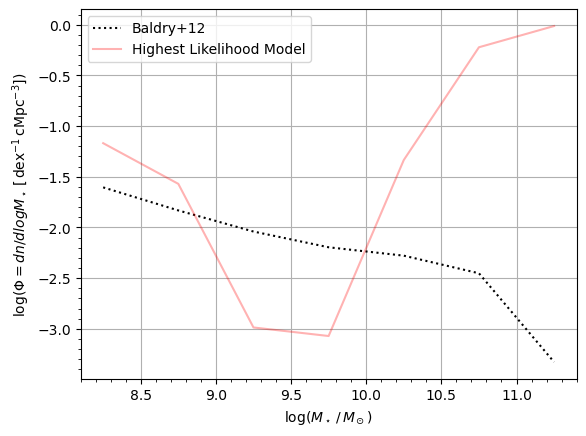

In [66]:
# Posterior parameters with highest probability
theta_max = flat_samples[np.argmax(sampler.get_log_prob(discard=nburn, thin=int(nburn/2), flat=True))]
print ('Theta max: ', theta_max)
best_fit_model = model(theta_max, x=data[0])

plt.clf()
plt.plot(data[0], data[1], color="black", ls=":", label="Baldry+12")
plt.plot(data[0], best_fit_model, color="r", alpha=0.3, label='Highest Likelihood Model')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\log(\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
plt.grid()
plt.minorticks_on()
plt.legend()
plt.show()

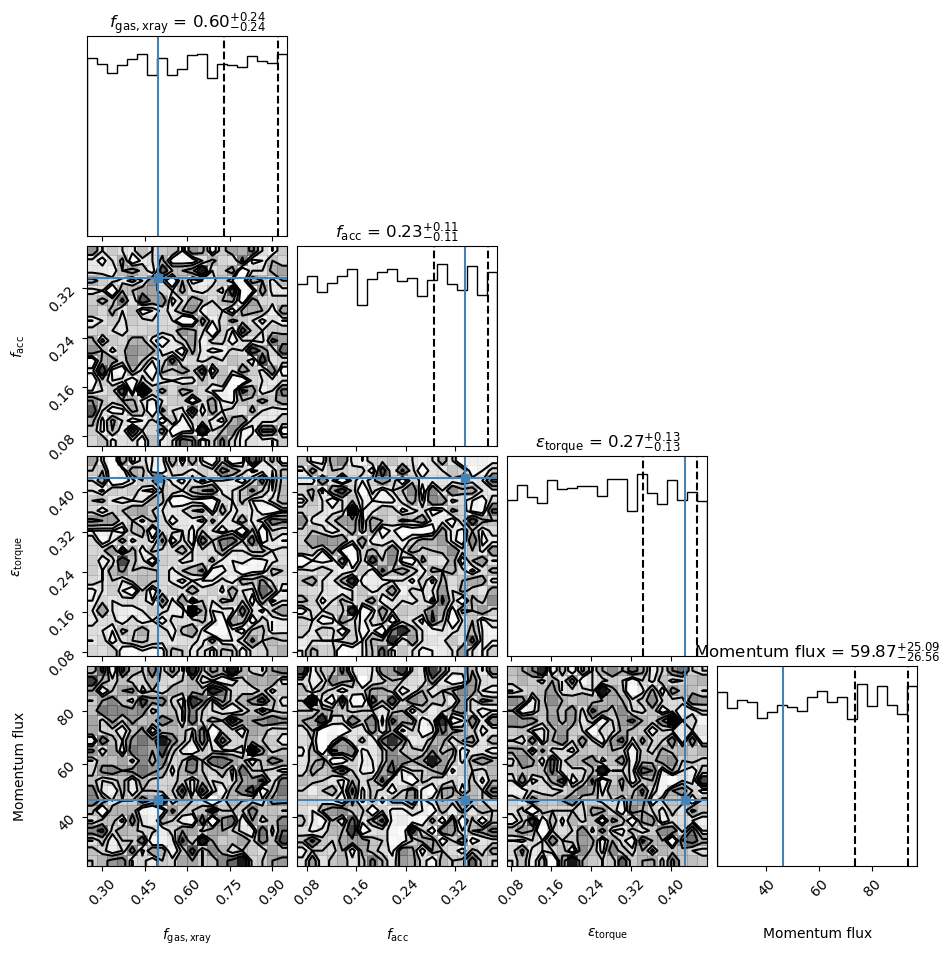

In [46]:
# Corner plot
labels = param_printable_names
#fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints=False, quantiles=[0.16, 0.5, 0.84])
fig = corner.corner(flat_samples, show_titles=True, labels=labels, plot_datapoints=False, quantiles=[0.68, 0.95],truths=list(pred_params_best_node.values()))